# Model Configuration Testing with Performance Optimizations

This notebook is designed for systematic hyperparameter optimization with **state-of-the-art performance optimizations** for high-end hardware (RTX 5080 + Ryzen 9 7950X). It allows testing different combinations of model parameters to find the optimal configuration for bird song classification.

## Configuration Parameters:
- **ADAM Optimizer**: Whether to use Adam optimizer (vs SGD)
- **Early Stopping Threshold**: Patience for early stopping
- **Batch Size**: Training batch size *(automatically optimized for AMP)*
- **Class Weights**: Whether to use class weights for imbalanced data
- **L2 Regularization**: Weight decay parameter
- **Learning Rate Schedule**: Type and parameters for LR scheduling
- **Initial Learning Rate**: Starting learning rate
- **Standardization**: Whether to standardize features
- **SpecAugment**: Whether to apply spectrogram augmentation
- **Noise Augment**: Whether to apply Gaussian noise augmentation

In [1]:
import os, sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import json
import seaborn as sns
from typing import Tuple
from datetime import datetime
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
else:
    print("⚠️  CUDA not available - running on CPU (will be slow)")

# Performance optimization settings
ENABLE_OPTIMIZATIONS = True  # Set to False to disable all optimizations
ENABLE_PARALLEL_FOLDS = False  # Set to True for cross-validation mode
MAX_PARALLEL_FOLDS = -1  # Adjust based on GPU memory

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
GPU Memory: 15.9 GB


In [2]:
def load_csv_data(file_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Reads the CSV with all the training data: grayscale log-mel spectrogram pixels, label and author of each sample
    And extracts them respectively, resizing the features to fit the CNN input shape (channel, height, width).

    Args:
        file_path (str): Path to the CSV file containing training data.

    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors from the CSV file. Features shape is (N x 70,112),
        while labels and authors are 1D arrays of size N, where N is the number of samples.
    """
    # Load training data
    df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Number of classes: {df['label'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")

    # Extract labels, authors, and features
    labels = df['label'].values.astype(np.int64)
    authors = df['author'].values
    features = df.drop(columns=['label', 'author']).values.astype(np.float32)
    print(f"Features shape before reshape: {features.shape} (should be N x 70112!)")

    # Convert to 0-1 range and reshape for CNN
    features /= 255.0
    features = features.reshape(-1, 1, 224, 313)

    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)
    print("Authors shape:", authors.shape)
    print("Unique classes:", len(np.unique(labels)))
    print("Unique authors:", len(np.unique(authors)))

    # No need for df variable after extracting features, release memory
    del df

    return features, labels, authors

In [3]:
def load_npy_data(specs_dir: str, specs_csv_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Load spectrograms from .npy files and metadata from CSV.
    
    Args:
        specs_dir (str): Directory containing .npy spectrogram files
        specs_csv_path (str): Path to CSV file containing metadata (filename, class_id, author)
    
    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors.
        Features are already normalized to [0,1] and shaped as (N, 1, 224, 313)
    """
    # Load metadata CSV
    df = pd.read_csv(specs_csv_path)
    
    print(f"Metadata shape: {df.shape}")
    print(f"Number of classes: {df['class_id'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")
    
    # Extract labels and authors
    labels = df['class_id'].values.astype(np.int64)
    authors = df['author'].values
    filenames = df['filename'].values
    
    # Load spectrograms from .npy files
    features_list = []
    valid_indices = []
    
    for i, filename in enumerate(filenames):
        spec_path = os.path.join(specs_dir, filename)
        
        if os.path.exists(spec_path):
            try:
                # Load .npy file - already normalized to [0,1] as float32
                spec_array = np.load(spec_path)
                
                # Add channel dimension: (1, height, width)
                spec_array = spec_array[np.newaxis, ...]
                
                features_list.append(spec_array)
                valid_indices.append(i)
                
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"File not found: {spec_path}")
    
    # Convert to numpy array
    features = np.array(features_list, dtype=np.float32)
    
    # Filter labels and authors to match loaded features
    labels = labels[valid_indices]
    authors = authors[valid_indices]
    
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Authors shape: {authors.shape}")
    print(f"Unique classes: {len(np.unique(labels))}")
    print(f"Unique authors: {len(np.unique(authors))}")
    print(f"Successfully loaded {len(features)} out of {len(filenames)} spectrograms")
    
    # Clean up
    del df
    
    return features, labels, authors

In [4]:
# New pipeline using .npy spectrograms from specs/ directory
specs_dir = os.path.join('..', 'database', 'specs')
specs_csv_path = os.path.join('..', 'database', 'meta', 'final_specs.csv')
features, labels, authors = load_npy_data(specs_dir, specs_csv_path)

Metadata shape: (2985, 4)
Number of classes: 33
Number of authors: 106
Features shape: (2985, 1, 224, 313)
Labels shape: (2985,)
Authors shape: (2985,)
Unique classes: 33
Unique authors: 106
Successfully loaded 2985 out of 2985 spectrograms


In [5]:
# # Keep the old CSV-based loading for compatibility (uncomment if needed)
# train_data_path = os.path.join('..', 'database', 'meta', 'final', 'train_data.csv')
# features, labels, authors = load_csv_data(train_data_path)

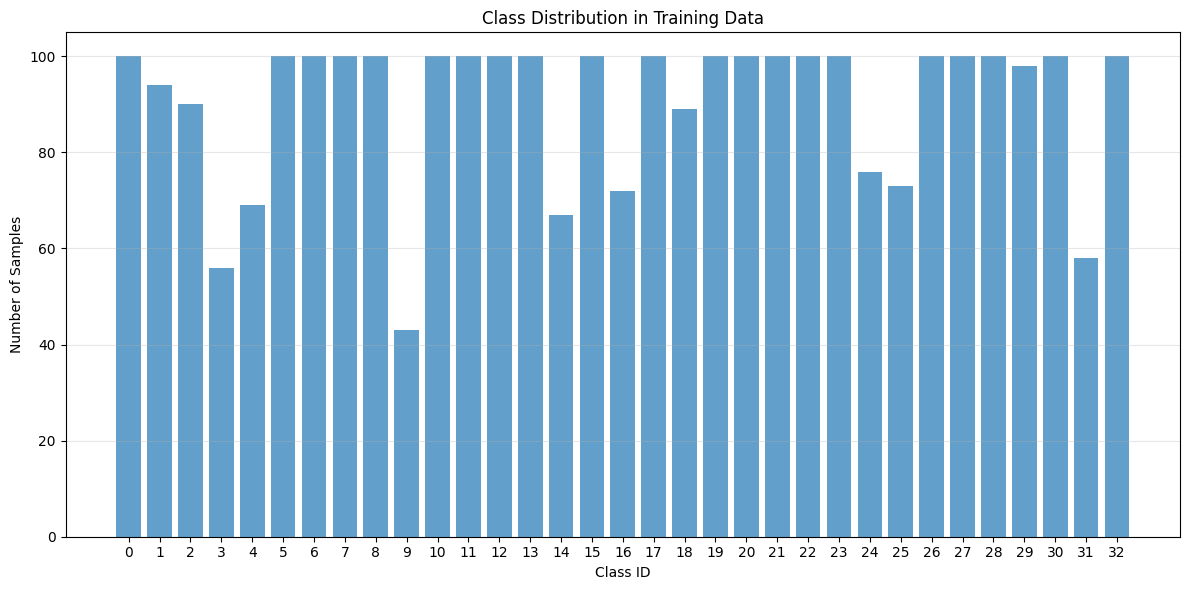

Average samples per class: 90.5


In [6]:
# Display class distribution
plt.figure(figsize=(12, 6))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

## Train-Val Split

In [7]:
# # Find best seed
# from utils.split import precompute_single_fold_split, precompute_kfold_splits, display_split_statistics

# # Pre-compute single fold split (for most configurations)
# single_fold_split = precompute_single_fold_split(
#     features=features,
#     labels=labels, 
#     authors=authors,
#     test_size=0.2,
#     max_attempts=250_000,
#     min_test_segments=5)

# # Pre-compute k-fold splits (for cross-validation configurations)  
# kfold_splits = precompute_kfold_splits(
#     features=features,
#     labels=labels,
#     authors=authors,
#     n_splits=4,
#     max_attempts=12_000, # mas para k-fold
#     min_val_segments=0)

# print(f"Single Fold Split Type: {type(single_fold_split)}, Shape: {len(single_fold_split)}")
# print(f"K-Fold Splits Type: {type(kfold_splits)}, Shape: {len(kfold_splits)}")

# # Display statistics for verification
# display_split_statistics(single_fold_split, "single")
# display_split_statistics(kfold_splits, "kfold")

In [8]:
# Split with a set seed, las que ya encontre arriba, para tardar menos
from utils.split import get_set_seed_indices, get_set_seed_kfold_indices, display_split_statistics
seed_single = 245323 # Quality: 0.2671
seed_kfold = 11052 # Quality: 0.3332

single_fold_split = get_set_seed_indices(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    seed=seed_single)

kfold_splits = get_set_seed_kfold_indices(
    features=features,
    labels=labels,
    authors=authors,
    n_splits=4,
    seed=seed_kfold)

display_split_statistics(single_fold_split, "single")
display_split_statistics(kfold_splits, "kfold")


📊 SINGLE SPLIT STATISTICS
----------------------------------------
Random seed: 245323
Train samples: 2328
Validation samples: 657
Split ratio: 77.99% - 22.01%
Quality score: 0.2671
----------------------------------------

📊 KFOLD SPLIT STATISTICS
----------------------------------------
Random seed: 11052
Number of folds: 4
Average quality score: 0.3332
  Fold 1: 2170 train, 815 val (72.70% - 27.30%)
  Fold 2: 2319 train, 666 val (77.69% - 22.31%)
  Fold 3: 2312 train, 673 val (77.45% - 22.55%)
  Fold 4: 2154 train, 831 val (72.16% - 27.84%)
----------------------------------------


## Training

In [9]:
# Define configuration templates for systematic testing
configurations = {
    'config0': {  # config16 - as is
        'name': 'Chaos Theory Adam',
        'use_adam': True,
        'estop_thresh': 37,
        'batch_size': 45,
        'use_class_weights': True,
        'l2_regularization': 3.7e-4,
        'lr_schedule': {'type': 'cosine', 'T_max': 73},
        'initial_lr': 0.00137,
        'standardize': False,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 247,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.73,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config1': {  # config9 - as is
        'name': 'Balanced Classes Focus',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 28,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config2': {  # config5 - as is
        'name': 'Small Batch High LR (AMP Optimized)',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 24,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.98},
        'initial_lr': 0.004,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 180,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config3': {  # config9 + noise_augment (spec+noise)
        'name': 'Balanced Classes Focus (Spec+Noise Aug)',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 28,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config4': {  # config9 + higher batch size
        'name': 'Balanced Classes (Higher Batch)',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 40,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config5': {  # config2 with config9's gamma/estop, more augmentation
        'name': 'Exponential LR + Dual Augment',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 40,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0025,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 200,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config6': {  # AdamW variant of config9
        'name': 'Balanced Classes AdamW',
        'use_adam': 'adamw',
        'estop_thresh': 35,
        'batch_size': 28,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config7': {  # config7 - heavy regularization, plateau schedule
        'name': 'Heavy Regularization (Optimized)',
        'use_adam': True,
        'estop_thresh': 60,
        'batch_size': 40,
        'use_class_weights': True,
        'l2_regularization': 1e-3,
        'lr_schedule': {'type': 'plateau', 'factor': 0.7, 'patience': 15},
        'initial_lr': 0.001,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 300,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.2,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config8' : {
        'name': 'Best Results Frankenstein',
        'use_adam': True,
        'estop_thresh': 36,
        'batch_size': 40,
        'use_class_weights': True,
        'l2_regularization': 0.0003,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.97},
        'initial_lr': 0.0024,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': True,
        'gradient_clipping': 1.0,
        'parallel_folds': False,
        'max_parallel_folds': 2,
        'optimize_dataloaders': True,
    }
}


In [11]:
import importlib
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# If you also want to reload the utils package itself
import utils
importlib.reload(utils)

# Reload all the utils modules you're importing
import utils.training_core
import utils.training_engine
import utils.models

importlib.reload(utils.training_core)
importlib.reload(utils.training_engine)
importlib.reload(utils.models)

# Re-import after reloading to get the updated versions
from utils.training_core import single_fold_training, cross_val_training
import utils.models as models
import utils.training_engine

# Initialize results storage
results_database = {}

print(f"Performance optimizations: {'ENABLED' if ENABLE_OPTIMIZATIONS else 'DISABLED'}")
if ENABLE_PARALLEL_FOLDS:
    print(f"Parallel fold training: ENABLED (max {MAX_PARALLEL_FOLDS} folds)")

Performance optimizations: ENABLED


In [12]:
# Track overall progress and performance metrics
successful_configs = 0
failed_configs = []
training_start_time = datetime.now()

for config_id, config in configurations.items():
    print(f"\n{'='*60}")
    print(f"TESTING {config_id.upper()}: {config['name']}")
    
    config_start_time = datetime.now()
    
    # Convert config to training_core format with optimizations
    training_config = {
        # Basic training parameters
        'num_epochs': config['num_epochs'],
        'batch_size': config['batch_size'],
        'learning_rate': config['initial_lr'],
        'use_class_weights': config['use_class_weights'],
        'early_stopping': config['estop_thresh'],
        'standardize': config['standardize'],
        'test_size': 0.2,
        'max_split_attempts': 5000,
        'min_test_segments': 5,
        'l2_regularization': config['l2_regularization'],
        'use_adam': config['use_adam'],
        'lr_schedule': config['lr_schedule'],
        
        # NEW PERFORMANCE OPTIMIZATIONS
        'mixed_precision': config.get('mixed_precision', False),
        'gradient_clipping': config.get('gradient_clipping', 0),
        'parallel_folds': config.get('parallel_folds', False),
        'max_parallel_folds': config.get('max_parallel_folds', 2),
        
        # Enhanced DataLoader settings (automatically optimized)
        'optimize_dataloaders': ENABLE_OPTIMIZATIONS,
        'debug_dataloaders': False,  # Set to True for debugging
        'benchmark_performance': True  # Enable performance tracking
    }
    
    # Execute training with performance monitoring
    training_start = time.time()
    
    # Choose training method based on parallel folds setting
    if training_config.get('parallel_folds', False):
        print(f"Training K-Fold Parallel with pre-made splits for {config_id}...")
        result, best_result = cross_val_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=models.BirdCNN,
            num_classes=len(np.unique(labels)),
            config=training_config,
            spec_augment=config['spec_augment'],
            gaussian_noise=config['noise_augment'],
            precomputed_splits=kfold_splits,  # Use pre-computed k-fold splits
            config_id=config_id  # Pass config_id for progress bar
        )
        # Extract single fold equivalent metrics for comparison
        if 'summary' in result:
            final_result = {
                'best_val_acc': result['summary']['mean_best_val_acc'],
                'best_val_f1': result['summary']['mean_best_val_f1'],
                'best_val_loss': result['summary']['mean_best_val_loss'],
                'training_type': 'cross_validation',
                'num_folds': training_config.get('k_folds', 4),
                'parallel_execution': True
            }
        else:
            final_result = best_result  # fallback
    else:
        print(f"Training Single-Fold with pre-made splits for {config_id}...")
        final_result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=models.BirdCNN,
            num_classes=len(np.unique(labels)),
            config=training_config,
            spec_augment=config['spec_augment'],
            gaussian_noise=config['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id=config_id  # Pass config_id for progress bar
        )
        final_result['training_type'] = 'single_fold'
        final_result['parallel_execution'] = False
    
    training_end = time.time()
    training_duration = training_end - training_start
    
    # Store results with optimization metadata
    config_end_time = datetime.now()
    
    results_database[config_id] = {
        'config': config,
        'result': final_result,
        'training_time_seconds': training_duration,
        'timestamp': config_end_time.isoformat(),
        'status': 'success',
        'optimization_metadata': {
            'mixed_precision_used': training_config.get('mixed_precision', False),
            'gradient_clipping_used': training_config.get('gradient_clipping', 0) > 0,
            'parallel_folds_used': training_config.get('parallel_folds', False),
            'optimized_dataloaders': training_config.get('optimize_dataloaders', False),
            'batch_size_optimized': config['batch_size'] > 32 if ENABLE_OPTIMIZATIONS else False
        }
    }
    
    successful_configs += 1
    
    # Performance reporting
    print(f"\n✓ {config_id} completed successfully!")
    print(f"  Best Val Accuracy: {final_result['best_val_acc']:.4f}")
    print(f"  Best Val F1 Score: {final_result['best_val_f1']:.4f}")
    
    # GPU memory status (if available)
    if torch.cuda.is_available():
        memory_used = torch.cuda.memory_allocated() / (1024**3)
        memory_total = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print(f"  GPU Memory: {memory_used:.1f}GB / {memory_total:.1f}GB ({memory_used/memory_total*100:.1f}%)")

training_end_time = datetime.now()
total_duration = (training_end_time - training_start_time).total_seconds()

print(f"\n{'='*80}")
print(f"Successful configurations: {successful_configs}/{len(configurations)}")
if failed_configs:
    print(f"Failed configurations: {', '.join(failed_configs)}")


TESTING CONFIG6: Best Results Frankenstein
Training Single-Fold with pre-made splits for config6...
Train size: 2328, Val size: 657


Config: config6 | TrLoss: 0.0058 | TrAcc: 1.0000 | ValLoss: 2.0412 | ValAcc: 0.5578:  95%|█████████▌| 209/220 [04:54<00:15,  1.41s/it]


Early stopped after 209 epochs (best at epoch 174)
Best - Val Acc: 0.5531, Val F1: 0.5416

✓ config6 completed successfully!
  Best Val Accuracy: 0.5531
  Best Val F1 Score: 0.5416
  GPU Memory: 0.0GB / 15.9GB (0.2%)

TESTING CONFIG8: 2nd Results Frankenstein
Training Single-Fold with pre-made splits for config8...
Train size: 2328, Val size: 657


Config: config8 | TrLoss: 0.0035 | TrAcc: 1.0000 | ValLoss: 2.0530 | ValAcc: 0.5156:  89%|████████▊ | 195/220 [04:29<00:34,  1.38s/it]


Early stopped after 195 epochs (best at epoch 160)
Best - Val Acc: 0.4953, Val F1: 0.4865

✓ config8 completed successfully!
  Best Val Accuracy: 0.4953
  Best Val F1 Score: 0.4865
  GPU Memory: 0.1GB / 15.9GB (0.4%)

Successful configurations: 2/2


## Results Analysis

Comprehensive analysis and visualization of all configuration results.

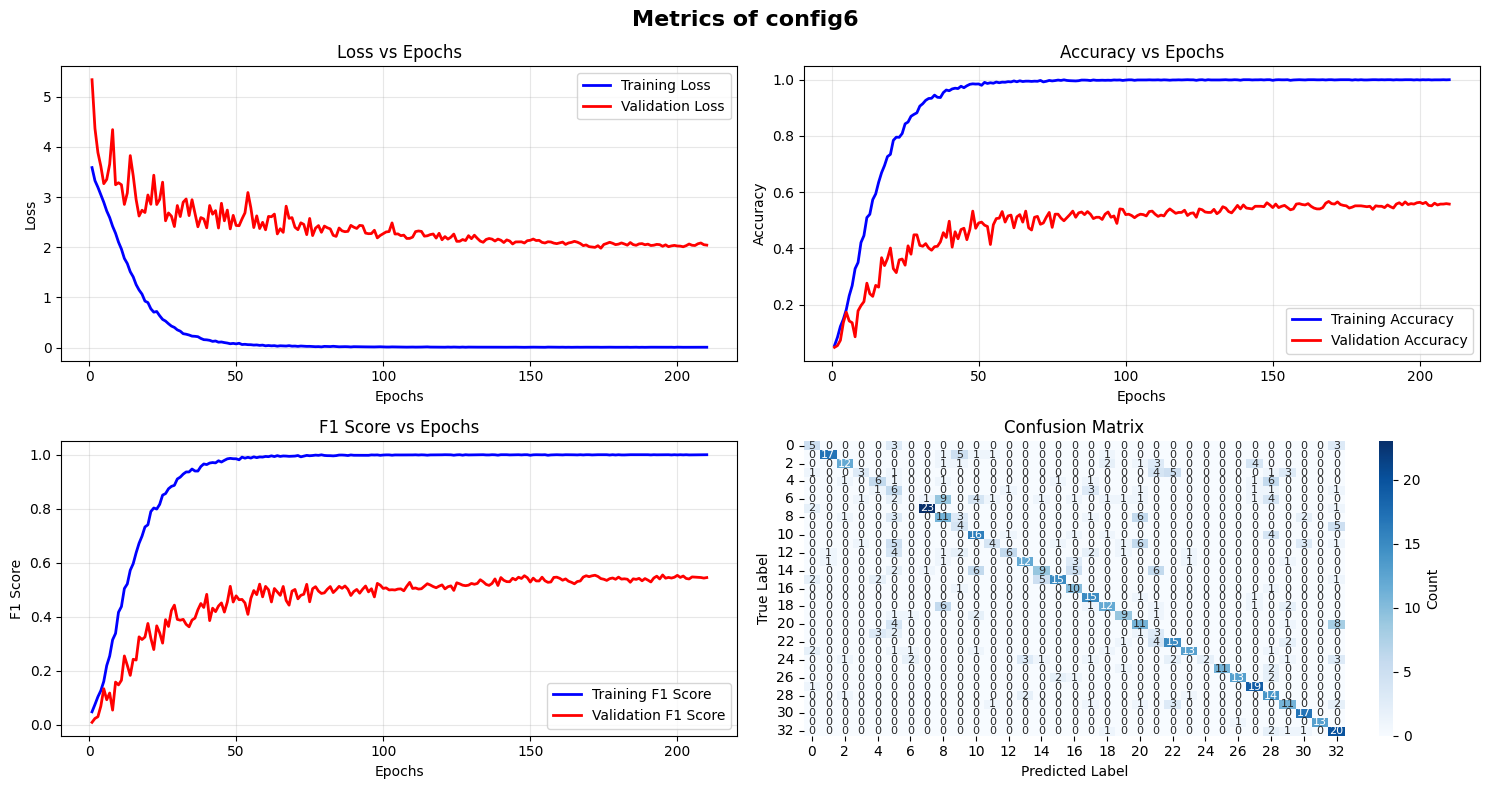

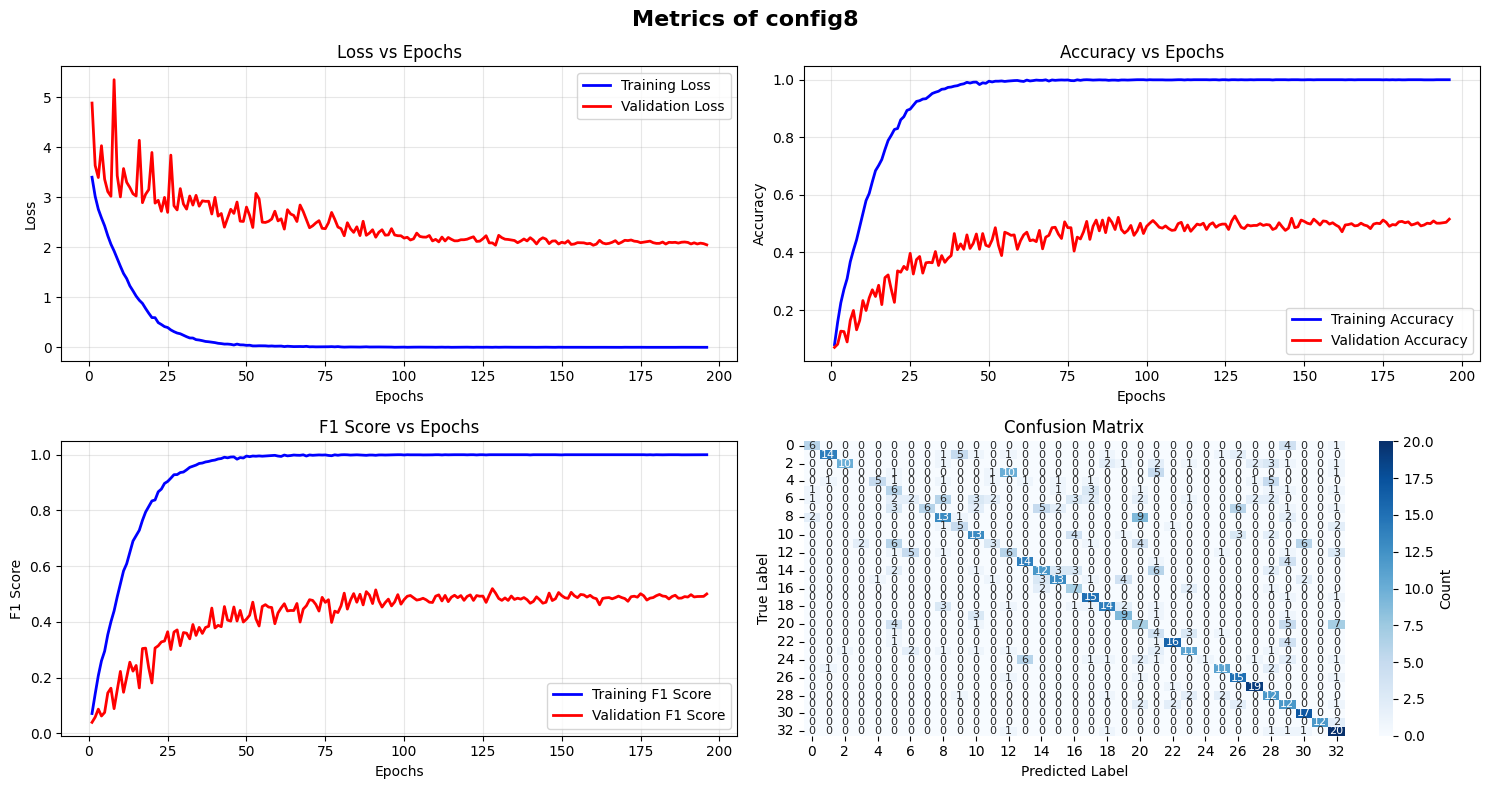

In [13]:
importlib.reload(utils.metrics)
from utils.metrics import plot_metrics

# Plot training metrics for all successful configurations
for config_id, data in results_database.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        plot_metrics(config_id, result)

In [14]:
# Create a simple table showing config_ids with their best validation accuracy and F1 scores
# Extract data from results_database
table_data = []
for config_id, data in results_database.items():
    if config_id == 'config20':
        continue
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        table_data.append({
            'config_id': config_id,
            'best_val_acc': result.get('best_val_acc', 0),
            'best_val_f1': result.get('best_val_f1', 0)
        })

# Create DataFrame and sort by best_val_f1 (descending)
results_table = pd.DataFrame(table_data)
results_table = results_table.sort_values('best_val_f1', ascending=False)

print("CONFIGURATION RESULTS TABLE (sorted by Best Val F1)")
print("=" * 55)
print(results_table.to_string(index=False, float_format='%.4f'))

CONFIGURATION RESULTS TABLE (sorted by Best Val F1)
config_id  best_val_acc  best_val_f1
  config6        0.5531       0.5416
  config8        0.4953       0.4865


In [ ]:
# Extract successful results for analysis
successful_results = {k: v for k, v in results_database.items() if v['status'] == 'success'}

if not successful_results:
    print("No successful configurations to analyze!")
else:
    print(f"Analyzing {len(successful_results)} successful configurations...")
    
    # Create results DataFrame with optimization metadata
    analysis_data = []
    for config_id, data in successful_results.items():
        config = data['config']
        result = data['result']
        opt_meta = data.get('optimization_metadata', {})
        
        row = {
            'config_id': config_id,
            'config_name': config['name'],
            'best_val_acc': result['best_val_acc'],
            'best_val_f1': result['best_val_f1'],
            'training_time_min': data['training_time_seconds'] / 60,
            'training_type': result.get('training_type', 'single_fold'),
            
            # Configuration parameters
            'use_adam': config['use_adam'],
            'estop_thresh': config['estop_thresh'],
            'batch_size': config['batch_size'],
            'use_class_weights': config['use_class_weights'],
            'l2_regularization': config['l2_regularization'],
            'has_lr_schedule': config['lr_schedule'] is not None,
            'lr_schedule_type': config['lr_schedule']['type'] if config['lr_schedule'] else 'none',
            'initial_lr': config['initial_lr'],
            'standardize': config['standardize'],
            'spec_augment': config['spec_augment'],
            'noise_augment': config['noise_augment'],
            'num_epochs': config['num_epochs'],
            
            # NEW OPTIMIZATION METRICS
            'mixed_precision_used': opt_meta.get('mixed_precision_used', False),
            'gradient_clipping_used': opt_meta.get('gradient_clipping_used', False),
            'parallel_folds_used': opt_meta.get('parallel_folds_used', False),
            'optimized_dataloaders': opt_meta.get('optimized_dataloaders', False),
            'batch_size_optimized': opt_meta.get('batch_size_optimized', False),
            'gradient_clipping_value': config.get('gradient_clipping', 0),
            'optimization_score': (
                opt_meta.get('mixed_precision_used', False) * 2 +
                opt_meta.get('gradient_clipping_used', False) * 1 +
                opt_meta.get('optimized_dataloaders', False) * 1 +
                opt_meta.get('batch_size_optimized', False) * 1
            )  # Score out of 5
        }
        analysis_data.append(row)
    
    results_df = pd.DataFrame(analysis_data)
    
    # Sort by F1 score (primary metric) - using best metrics from early stopping
    results_df = results_df.sort_values('best_val_f1', ascending=False)
    
    print("TOP 10 CONFIGURATIONS BY BEST F1 SCORE (from early stopping):")
    print("="*70)
    top_10_display = results_df.head(10)[['config_id', 'config_name', 'best_val_f1', 'best_val_acc', 
                                        'training_time_min', 'mixed_precision_used', 'optimization_score']]
    # Round numeric columns to 2 decimal places for better readability
    top_10_display_formatted = top_10_display.copy()
    top_10_display_formatted['best_val_f1'] = top_10_display_formatted['best_val_f1'].round(4)
    top_10_display_formatted['best_val_acc'] = top_10_display_formatted['best_val_acc'].round(4)
    top_10_display_formatted['training_time_min'] = top_10_display_formatted['training_time_min'].round(4)
    print(top_10_display_formatted.to_string(index=False))
    
    # Performance optimization analysis
    if ENABLE_OPTIMIZATIONS:
        print(f"\n🚀 PERFORMANCE OPTIMIZATION ANALYSIS:")
        print("="*50)
        
        optimized_configs = results_df[results_df['mixed_precision_used'] == True]
        traditional_configs = results_df[results_df['mixed_precision_used'] == False]
        
        if len(optimized_configs) > 0:
            print(f"Configurations with optimizations: {len(optimized_configs)}")
            print(f"Average Best F1 (optimized): {optimized_configs['best_val_f1'].mean():.4f}")
            print(f"Average training time (optimized): {optimized_configs['training_time_min'].mean():.1f} min")
            
            if len(traditional_configs) > 0:
                print(f"Average Best F1 (traditional): {traditional_configs['best_val_f1'].mean():.4f}")
                print(f"Average training time (traditional): {traditional_configs['training_time_min'].mean():.1f} min")
                
                # Calculate improvements
                f1_improvement = optimized_configs['best_val_f1'].mean() - traditional_configs['best_val_f1'].mean()
                time_improvement = traditional_configs['training_time_min'].mean() / optimized_configs['training_time_min'].mean()
                
                print(f"\n📊 Optimization Impact:")
                print(f"   • Best F1 Score improvement: {f1_improvement:+.4f}")
                print(f"   • Speed improvement: {time_improvement:.2f}x faster")
        
        # Optimization feature correlation
        print(f"\n🔧 Optimization Feature Analysis:")
        opt_features = ['mixed_precision_used', 'gradient_clipping_used', 'batch_size_optimized']
        for feature in opt_features:
            if feature in results_df.columns:
                feature_on = results_df[results_df[feature] == True]['best_val_f1'].mean()
                feature_off = results_df[results_df[feature] == False]['best_val_f1'].mean()
                improvement = feature_on - feature_off
                print(f"   • {feature}: {improvement:+.4f} Best F1 improvement")
    
    # Best configuration details
    best_config_id = results_df.iloc[0]['config_id']
    best_config_data = successful_results[best_config_id]
    
    print(f"\n🏆 BEST CONFIGURATION: {best_config_id}")
    print(f"Name: {best_config_data['config']['name']}")
    print(f"Best Val F1: {results_df.iloc[0]['best_val_f1']:.4f}")
    print(f"Best Val Accuracy: {results_df.iloc[0]['best_val_acc']:.4f}")
    print(f"Training Time: {results_df.iloc[0]['training_time_min']:.1f} minutes")
    print(f"Optimizations Used: {results_df.iloc[0]['optimization_score']}/5")
    
    if results_df.iloc[0]['mixed_precision_used']:
        print("✅ Used Mixed Precision Training")
    if results_df.iloc[0]['gradient_clipping_used']:
        print(f"✅ Used Gradient Clipping ({results_df.iloc[0]['gradient_clipping_value']})")
    if results_df.iloc[0]['optimized_dataloaders']:
        print("✅ Used Optimized DataLoaders")
    if results_df.iloc[0]['batch_size_optimized']:
        print("✅ Used Optimized Batch Size")

In [ ]:
# Visualization of results
if len(successful_results) > 0:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Configuration Results Analysis (Best Metrics from Early Stopping)', fontsize=16, fontweight='bold')
    
    # 1. F1 Score comparison
    ax1 = axes[0, 0]
    results_df_plot = results_df.head(15)  # Top 15 for readability
    bars1 = ax1.bar(range(len(results_df_plot)), results_df_plot['best_val_f1'], alpha=0.7, color='skyblue')
    ax1.set_title('Best Validation F1 Score by Configuration')
    ax1.set_xlabel('Configuration Rank')
    ax1.set_ylabel('Best F1 Score')
    ax1.set_xticks(range(len(results_df_plot)))
    ax1.set_xticklabels(results_df_plot['config_id'], rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. Accuracy vs F1 scatter
    ax2 = axes[0, 1]
    scatter = ax2.scatter(results_df['best_val_acc'], results_df['best_val_f1'], 
                        c=results_df['training_time_min'], cmap='viridis', alpha=0.7, s=100)
    ax2.set_xlabel('Best Validation Accuracy')
    ax2.set_ylabel('Best Validation F1 Score')
    ax2.set_title('Best Accuracy vs Best F1 Score (colored by training time)')
    plt.colorbar(scatter, ax=ax2, label='Training Time (min)')
    
    # Add best point annotation
    best_acc = results_df.iloc[0]['best_val_acc']
    best_f1 = results_df.iloc[0]['best_val_f1']
    ax2.annotate(f'Best: {best_config_id}', xy=(best_acc, best_f1), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # 3. Parameter impact - Batch size
    ax3 = axes[0, 2]
    batch_impact = results_df.groupby('batch_size')['best_val_f1'].agg(['mean', 'count']).reset_index()
    bars3 = ax3.bar(batch_impact['batch_size'], batch_impact['mean'], alpha=0.7, color='lightcoral')
    ax3.set_title('Average Best F1 Score by Batch Size')
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Average Best F1 Score')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, row in batch_impact.iterrows():
        ax3.text(row['batch_size'], row['mean'] + 0.002, f'n={row["count"]}', ha='center', va='bottom', fontsize=8)
    
    # 4. Learning rate impact
    ax4 = axes[1, 0]
    lr_bins = pd.cut(results_df['initial_lr'], bins=5)
    lr_impact = results_df.groupby(lr_bins)['best_val_f1'].agg(['mean', 'count']).reset_index()
    lr_labels = [f'{interval.left:.4f}-{interval.right:.4f}' for interval in lr_impact['initial_lr']]
    bars4 = ax4.bar(range(len(lr_labels)), lr_impact['mean'], alpha=0.7, color='lightgreen')
    ax4.set_title('Average Best F1 Score by Learning Rate Range')
    ax4.set_xlabel('Learning Rate Range')
    ax4.set_ylabel('Average Best F1 Score')
    ax4.set_xticks(range(len(lr_labels)))
    ax4.set_xticklabels(lr_labels, rotation=45)
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Augmentation impact
    ax5 = axes[1, 1]
    augment_combinations = results_df.groupby(['spec_augment', 'noise_augment'])['best_val_f1'].agg(['mean', 'count']).reset_index()
    augment_labels = []
    for _, row in augment_combinations.iterrows():
        spec = 'Spec' if row['spec_augment'] else 'NoSpec'
        noise = 'Noise' if row['noise_augment'] else 'NoNoise'
        augment_labels.append(f'{spec}+{noise}')
    
    bars5 = ax5.bar(range(len(augment_labels)), augment_combinations['mean'], alpha=0.7, color='orange')
    ax5.set_title('Average Best F1 Score by Augmentation Strategy')
    ax5.set_xlabel('Augmentation Combination')
    ax5.set_ylabel('Average Best F1 Score')
    ax5.set_xticks(range(len(augment_labels)))
    ax5.set_xticklabels(augment_labels, rotation=45)
    ax5.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, row in augment_combinations.iterrows():
        ax5.text(i, row['mean'] + 0.002, f'n={row["count"]}', ha='center', va='bottom', fontsize=8)
    
    # 6. Training time vs performance
    ax6 = axes[1, 2]
    ax6.scatter(results_df['training_time_min'], results_df['best_val_f1'], alpha=0.7, s=100, color='purple')
    ax6.set_xlabel('Training Time (minutes)')
    ax6.set_ylabel('Best Validation F1 Score')
    ax6.set_title('Training Time vs Best Performance')
    ax6.grid(alpha=0.3)
    
    # Add trendline
    z = np.polyfit(results_df['training_time_min'], results_df['best_val_f1'], 1)
    p = np.poly1d(z)
    ax6.plot(results_df['training_time_min'], p(results_df['training_time_min']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df.to_csv('../database/meta/configuration_results.csv', index=False)
    print(f"\n💾 Results saved to ../database/meta/configuration_results.csv")

## Configuration Recommendations

Based on the results, provide recommendations for future configurations.

In [ ]:
if len(successful_results) > 0:
    print("🎯 OPTIMIZED CONFIGURATION RECOMMENDATIONS (based on best early stopping results)")
    print("="*80)
    
    # Analyze best performing configurations
    top_5 = results_df.head(5)
    
    # Extract common patterns from top performers
    common_patterns = {}
    
    # Optimizer preference
    adam_count = top_5['use_adam'].sum()
    common_patterns['optimizer'] = 'Adam' if adam_count >= 3 else 'Mixed'
    
    # Batch size trends (consider optimization adjustments)
    avg_batch_size = top_5['batch_size'].mean()
    common_patterns['batch_size_range'] = f"{top_5['batch_size'].min()}-{top_5['batch_size'].max()}"
    
    # Learning rate trends
    avg_lr = top_5['initial_lr'].mean()
    common_patterns['lr_range'] = f"{top_5['initial_lr'].min():.4f}-{top_5['initial_lr'].max():.4f}"
    
    # Regularization trends
    avg_l2 = top_5['l2_regularization'].mean()
    common_patterns['l2_range'] = f"{top_5['l2_regularization'].min():.2e}-{top_5['l2_regularization'].max():.2e}"
    
    # Augmentation preferences
    spec_aug_count = top_5['spec_augment'].sum()
    noise_aug_count = top_5['noise_augment'].sum()
    
    # NEW: Optimization preferences
    mixed_precision_count = top_5['mixed_precision_used'].sum()
    gradient_clip_count = top_5['gradient_clipping_used'].sum()
    optimized_batch_count = top_5['batch_size_optimized'].sum()
    
    print("PATTERNS FROM TOP 5 BEST CONFIGURATIONS:")
    print("-"*45)
    print(f"• Preferred Optimizer: {common_patterns['optimizer']}")
    print(f"• Effective Batch Size Range: {common_patterns['batch_size_range']}")
    print(f"• Optimal Learning Rate Range: {common_patterns['lr_range']}")
    print(f"• L2 Regularization Range: {common_patterns['l2_range']}")
    print(f"• SpecAugment Usage: {spec_aug_count}/5 top configs")
    print(f"• Noise Augmentation Usage: {noise_aug_count}/5 top configs")
    
    # Specific recommendations
    print(f"\nRECOMMENDED OPTIMIZED CONFIGURATION:")
    print("-"*50)
    
    best_config = successful_results[results_df.iloc[0]['config_id']]['config']
    
    # Base configuration from results
    recommended_config = {
        'name': 'Optimized Based on Best Early Stopping Results',
        'use_adam': True,
        'estop_thresh': int(top_5['estop_thresh'].median()),
        'batch_size': int(top_5['batch_size'].median()),
        'use_class_weights': top_5['use_class_weights'].mode()[0],
        'l2_regularization': top_5['l2_regularization'].median(),
        'lr_schedule': best_config['lr_schedule'],
        'initial_lr': top_5['initial_lr'].median(),
        'standardize': True,  # Almost always beneficial
        'spec_augment': spec_aug_count >= 3,
        'noise_augment': noise_aug_count >= 3,
        'num_epochs': int(top_5['num_epochs'].median()),
        
        # NEW: Optimization recommendations based on results
        'mixed_precision': mixed_precision_count >= 3,
        'gradient_clipping': top_5['gradient_clipping_value'].median() if gradient_clip_count >= 3 else 0,
        'parallel_folds': False,  # For single fold; set True for cross-validation
        'max_parallel_folds': 2,  # Conservative for RTX 5080
        'optimize_dataloaders': True,  # Always beneficial
    }
    
    print("# OPTIMIZED CONFIGURATION FOR RTX 5080 + Ryzen 9 7950X")
    print("optimized_config = {")
    for key, value in recommended_config.items():
        if isinstance(value, str):
            print(f"    '{key}': '{value}',")
        else:
            print(f"    '{key}': {value},")
    print("}")
    
    # Performance expectations with optimizations
    expected_f1 = top_5['best_val_f1'].mean()
    f1_std = top_5['best_val_f1'].std()
    expected_time = top_5['training_time_min'].mean()
    
else:
    print("❌ No successful configurations to analyze!")
    print("Check the failed configurations and adjust parameters.")
    print("\n🔧 Troubleshooting Optimization Issues:")
    print("• Reduce batch_size if getting OOM errors")
    print("• Set mixed_precision=False if encountering numerical instability")
    print("• Lower gradient_clipping value if training becomes unstable")

In [ ]:
# Save complete results for future reference
if len(successful_results) > 0:
    # Create a clean version of results_database without problematic objects
    clean_results_database = {}
    for config_id, data in results_database.items():
        clean_data = {
            'config': data['config'],
            'status': data['status'],
            'optimization_metadata': data.get('optimization_metadata', {}),
            'timestamp': data.get('timestamp', ''),
            'training_time_seconds': data.get('training_time_seconds', 0)
        }
        
        if data['status'] == 'success' and data.get('result'):
            # Extract only serializable parts of the result
            result = data['result']
            clean_data['result'] = {
                'final_val_acc': result.get('final_val_acc', 0),
                'final_val_f1': result.get('final_val_f1', 0),
                'final_val_loss': result.get('final_val_loss', 0),
                'best_val_acc': result.get('best_val_acc', 0),
                'best_val_f1': result.get('best_val_f1', 0),
                'training_time': result.get('training_time', 0),
                'training_type': result.get('training_type', 'single_fold'),
                'parallel_execution': result.get('parallel_execution', False),
                # Include history without problematic objects
                'history': {
                    'early_stopped': result.get('history', {}).get('early_stopped', False),
                    'best_epoch': result.get('history', {}).get('best_epoch', 0),
                    'total_epochs': result.get('history', {}).get('total_epochs', 0)
                }
            }
        elif data['status'] == 'failed':
            clean_data['error'] = data.get('error', 'Unknown error')
        
        clean_results_database[config_id] = clean_data
    
    # Create a comprehensive results file
    complete_results = {
        'metadata': {
            'test_date': training_start_time.isoformat(),
            'total_configs_tested': len(configurations),
            'successful_configs': len(successful_results),
            'failed_configs': len(failed_configs),
            'total_duration_hours': total_duration / 3600,
            'dataset_info': {
                'total_samples': len(features),
                'num_classes': len(np.unique(labels)),
                'num_authors': len(np.unique(authors)),
                'feature_shape': list(features.shape)
            }
        },
        'configurations': configurations,
        'results': clean_results_database,
        'analysis': {
            'top_10_configs': results_df.head(10).to_dict('records'),
        }
    }
    
    # Convert numpy types to native Python types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return bool(obj)
        return obj
    
    # Save as JSON for future analysis
    try:
        # Save to CSV
        results_df.to_csv('../models/reports/configuration_results.csv', index=False)

        with open('../models/reports/complete_configuration_results.json', 'w') as f:
            # Clean the data for JSON serialization
            clean_results = json.loads(json.dumps(complete_results, default=convert_numpy))
            json.dump(clean_results, f, indent=2)
        
        print("💾 Complete results saved to:")
        print("  - ../models/reports/configuration_results.csv (tabular data)")
        print("  - ../models/reports/complete_configuration_results.json (full results)")
        
    except Exception as e:
        print(f"⚠️  Warning: Could not save JSON file due to serialization issue: {e}")
        print("💾 Results saved to CSV only:")
        print("  - ../models/reports/configuration_results.csv (tabular data)")
    
    print(f"\n🎉 Configuration testing completed successfully!")
    print(f"Best configuration: {results_df.iloc[0]['config_id']} with F1 score of {results_df.iloc[0]['final_val_f1']:.4f}")
else:
    print("❌ No results to save - all configurations failed!")